In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 28/Oct/2020 11:58

In [2]:
%%capture
# %matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np


# Experiments
import run
from uniswap.model.sys_params import sys_params

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (147437, 5, 5, 3)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 135.50s
Execution in 139.0s


In [4]:
fees = [(1-(fee/1000))*100 for fee in sys_params['fee_numerator']]

## ANALYSIS

In [5]:
models = list()
for i in experiments['subset'].unique():
    models.append(experiments.loc[experiments['subset']==i,['DAI_balance', 'ETH_balance', 'UNI_supply']])
    
for df in models:
    df.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']
    df.reset_index(inplace=True)

In [6]:
UNI_df = pd.read_pickle('./uniswap_events.pickle')
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

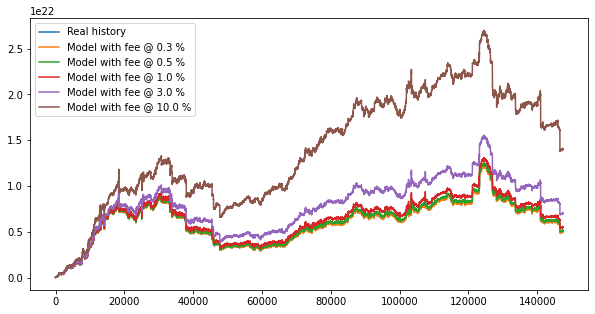

In [7]:
nmodels = len(models)

fig, axs = plt.subplots(figsize=(10,5))

plt.close()

axs.plot(real_history['real_ETH_balance'], label='Real history')

for i in range(nmodels):
    axs.plot(models[i]['model_ETH_balance'], label='Model with fee @ {:.1f} %'.format(fees[i]))

axs.legend(loc='upper left')
fig

In [8]:
df = experiments

prev_dai = pd.Series([np.nan]).append(df['DAI_balance'][:-1]).reset_index(drop=True)
prev_eth = pd.Series([np.nan]).append(df['ETH_balance'][:-1]).reset_index(drop=True)
df['delta_dai'] = df['DAI_balance'].diff()
df['delta_eth'] = df['ETH_balance'].diff()
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df['volume'] = df['volume'].fillna(0)
df = df.drop(columns=['delta_dai','delta_eth','istrade'])

In [9]:
def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

In [10]:
plot_data = experiments.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']

a = 0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']
plot_data['50_50_hodler_value'] = a.values

a = plot_data['50_50_hodler_value']/plot_data['50_50_hodler_value'][0] - 1
plot_data['50_50_hodler_return'] = a.values

a = plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1
plot_data['UNI_hodler_return'] = a.values

a = plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1
plot_data['ETH_hodler_return'] = a.values

plots = list()

for i in plot_data['subset'].unique():
    plots.append(plot_data[plot_data['subset'] == i])
for df in plots:
    df.reset_index(inplace=True)
    
plot_data

,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep,delta_dai,delta_eth,istrade,volume,ETH_price_DAI,UNI_price_DAI,50_50_hodler_value,50_50_hodler_return,UNI_hodler_return,ETH_hodler_return
0,5900,30,30,0,0,1,0,0,NaN,NaN,False,0,196.667,393.333,196.667,0,0,0
1,5905,29.9747,30,0,0,1,1,1,5000000000000000000,-25326059253325791,True,5,197,393.667,196.833,0.000846544,0.000847458,0.00169309
2,5907,29.9646,30,0,0,1,1,2,2000000000000000000,-10118429075406013,True,2,197.133,393.8,196.9,0.00118536,0.00118644,0.00237072
3,5905.04,29.9746,30,0,0,1,1,3,-1964761376358359468,10000000000000000,True,1.96476,197.002,393.669,196.834,0.000851512,0.00085343,0.00170302
4,5903.07,29.9846,30,0,0,1,1,4,-1963452825230191574,10000000000000000,True,1.96345,196.87,393.538,196.769,0.000517996,0.000520642,0.00103599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737185,1.85359e+06,14042.8,120.44,0,4,4,1,147433,-191608259994818512379,1612734329668653056,True,191.608,131.995,30780.2,164.331,-0.164418,77.2546,-0.328837
737186,1.85341e+06,14044.2,120.44,0,4,4,1,147434,-170649683038640609218,1436626766475589120,True,170.65,131.97,30777.3,164.318,-0.164484,77.2474,-0.328967
737187,1.85435e+06,14037.9,120.44,0,4,4,1,147435,932828026228980056064,-6358765674204256669,True,932.828,132.096,30792.8,164.381,-0.164163,77.2868,-0.328325
737188,1.85449e+06,14036.9,120.44,0,4,4,1,147436,145539841500000000000,-991525597132256289,True,145.54,132.116,30795.2,164.391,-0.164113,77.293,-0.328225


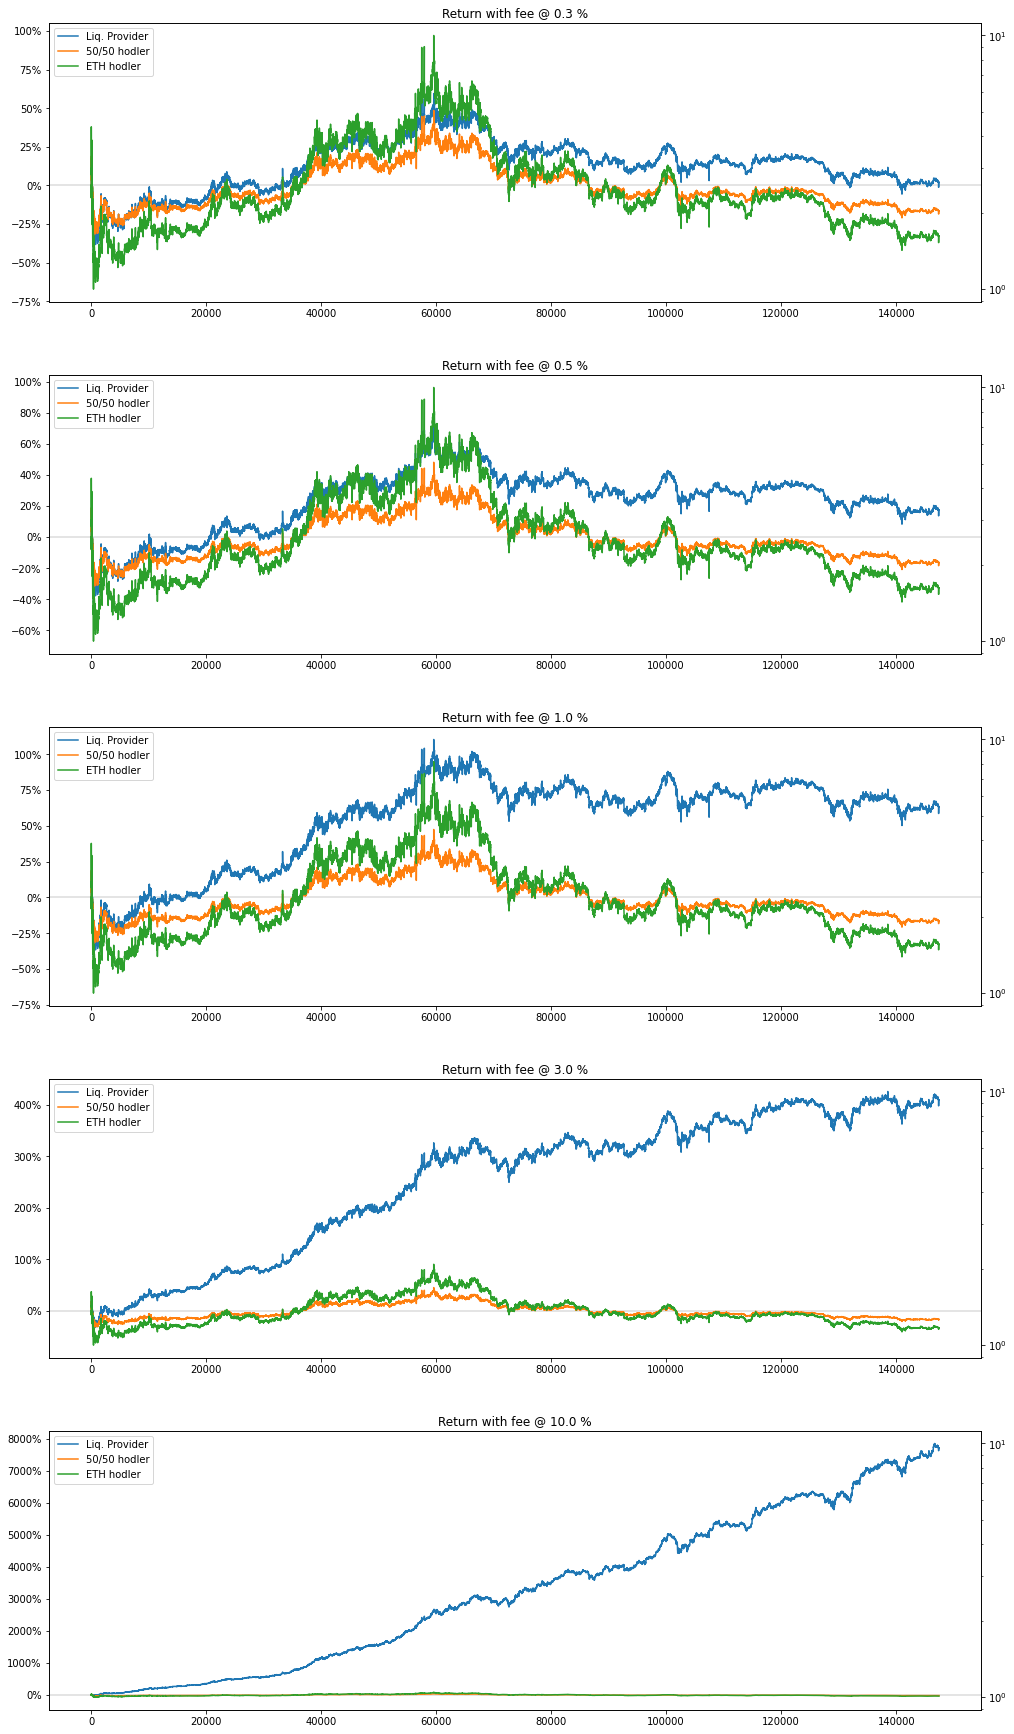

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
from matplotlib import cm
import matplotlib.ticker as ticker

nplots = len(plots)

fig, axs = plt.subplots(ncols=1, nrows=nplots,
                        figsize=(15,5*nplots))

plt.close()

for i in range(nplots):
    axs[i].axhline(0, color='gainsboro')
    ema = ExpMovingAverage(plots[i]['UNI_hodler_return'], 1)
    axs[i].plot(ema, label=f'Liq. Provider')
    axs[i].plot(plots[i]['50_50_hodler_return'], label=f'50/50 hodler')
    axs[i].plot(plots[i]['ETH_hodler_return'], label=f'ETH hodler')
    axs[i].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    axs[i].yaxis.tick_right()
    axs[i].legend(loc='upper left')
    axs[i].set_title('Return with fee @ {:.1f} %'.format(fees[i]))
    sec_ax = axs[i].twinx()
#     sec_ax.plot(plot_data.loc[i]['volume'], label='Volume')
    sec_ax.set_yscale('log')
    
fig.tight_layout(pad=4.0)
fig